# ADA Price Prediction using SARIMAX

## 1. Sourcing and Loading

### Load relevant librarie

In [ ]:
#!pip install fredapi
#!pip install load_dotenv

In [101]:
import yfinance as yf
import requests
from datetime import date
import pandas as pd
import numpy as np
from datetime import datetime

In [114]:
#File and name management libraries
import os
import shutil

#Math & data handling libraries
import pandas as pd
import numpy as np

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#dates and timeframe libraries
import datetime
import matplotlib.dates as mdates

#API
import requests


### Load the data

In [ ]:
TARGET_FEATURE = "ADA"

In [ ]:
# Get today's date
today = date.today()

In [ ]:
'''
from dotenv import load_dotenv
#Load secret api_key from .env file
load_dotenv()

api_key = os.getenv('eia_api_key')
#print('eia_api_key: ', api_key)
'''

### Read data

In [102]:
# Get dates
START_DATE = "2020-01-01"
print(f"Start date: {START_DATE}")

TODAY = datetime.today().date() # get today's date
print(f"Current date: {TODAY}")

Start date: 2020-01-01
Current date: 2024-03-12


#### Crypto

In [103]:

# Define the symbols for the data you want to download from CoinGecko
coingecko_symbols = ['bitcoin', 'ethereum', 'cardano']

# Define the start and end dates
start_date = START_DATE
end_date = TODAY  

# Convert the start date to a datetime.date object
start_date = datetime.strptime(start_date, '%Y-%m-%d').date()

# Calculate the number of days between the start and end dates
days = (end_date - start_date).days

# Initialize an empty DataFrame to store the data
df_crypto = pd.DataFrame()

# Iterate over the CoinGecko symbols
for symbol in coingecko_symbols:
    # Define the CoinGecko API URL for the symbol's market chart
    url = f"https://api.coingecko.com/api/v3/coins/{symbol}/market_chart"

    # Define the parameters for the GET request
    params = {
        'vs_currency': 'usd',
        'days': days
    }

    # Send a GET request to the CoinGecko API
    response = requests.get(url, params=params)

    # Convert the response to JSON
    crypto_data = response.json()

    # Convert the prices data to a DataFrame
    crypto_df = pd.DataFrame(crypto_data['prices'], columns=['time', symbol])

    # Convert the time column to datetime
    crypto_df['time'] = pd.to_datetime(crypto_df['time'], unit='ms')

    # Set the time column as the index
    crypto_df.set_index('time', inplace=True)

    # Rename the symbol column to the symbol name
    crypto_df.rename(columns={symbol: symbol.upper()}, inplace=True)

    # If the data DataFrame is empty, copy the crypto_df DataFrame
    if df_crypto.empty:
        df_crypto = crypto_df.copy()
    else:
        # Otherwise, join the crypto_df DataFrame to the data DataFrame
        df_crypto = df_crypto.join(crypto_df)

# Fetch the Bitcoin dominance rate
url = "https://api.coingecko.com/api/v3/global"
response = requests.get(url)
global_data = response.json()
bitcoin_dominance = global_data['data']['market_cap_percentage']['btc']

# Add the Bitcoin dominance rate to the DataFrame
df_crypto['BTC_Dominance'] = bitcoin_dominance

# Display the DataFrame
display(df_crypto)

,BITCOIN,ETHEREUM,CARDANO,BTC_Dominance
time,,,,
2020-01-02 00:00:00,7193.754668,130.484685,0.033362,49.904103
2020-01-03 00:00:00,6963.853354,127.045258,0.032618,49.904103
2020-01-04 00:00:00,7300.346935,133.702649,0.033967,49.904103
2020-01-05 00:00:00,7351.377053,134.136883,0.034298,49.904103
2020-01-06 00:00:00,7349.972248,135.005714,0.034427,49.904103
...,...,...,...,...
2024-03-09 00:00:00,68315.251921,3893.613884,0.724738,49.904103
2024-03-10 00:00:00,68508.003963,3916.041188,0.744975,49.904103
2024-03-11 00:00:00,69075.666882,3887.473105,0.716058,49.904103


#### Financial Indexes

In [104]:
#Define the symbols for the data you want to download from yfinance
yfinance_symbols = ['^IXIC', '^DJI', '^GSPC', 'GC=F', 'DX-Y.NYB']

# Get today's date
today = date.today()

# Download stock data from yfinance and save into DataFrame
data_yfinance = yf.download(yfinance_symbols, start=START_DATE, end=TODAY)['Adj Close']

data_yfinance.columns = ['NASDAQ', 'DOW', 'SP500', 'GOLD', 'USD_IDX']
display(data_yfinance)


[                       0%%                      ]

[*********************100%%**********************]  5 of 5 completed


,NASDAQ,DOW,SP500,GOLD,USD_IDX
Date,,,,,
2020-01-02,96.849998,1524.500000,28868.800781,3257.850098,9092.190430
2020-01-03,96.839996,1549.199951,28634.880859,3234.850098,9020.769531
2020-01-06,96.669998,1566.199951,28703.380859,3246.280029,9071.469727
2020-01-07,96.980003,1571.800049,28583.679688,3237.179932,9068.580078
2020-01-08,97.300003,1557.400024,28745.089844,3253.050049,9129.240234
...,...,...,...,...,...
2024-03-05,103.800003,2133.500000,38585.191406,5078.649902,15939.589844
2024-03-06,103.370003,2150.300049,38661.050781,5104.759766,16031.540039
2024-03-07,102.820000,2158.000000,38791.351562,5157.359863,16273.379883


## 2. Data preperation

## 2. Cleaning, transforming and visualizing

In [105]:
TARGET_FEATURE = 'CARDANO'

In [139]:
#reset index
df1 = df_crypto.reset_index()
df2 = data_yfinance.reset_index()

# Convert 'time' in df1 to date format (remove time)
df1['time'] = pd.to_datetime(df1['time']).dt.date

# Convert 'date' in df2 to date format
df2['Date'] = pd.to_datetime(df2['Date']).dt.date

# Now you can merge on 'time' and 'date'
merged_df = pd.merge(df1, df2, left_on='time', right_on='Date').drop('time', axis = 1)
merged_df.set_index('Date', inplace= True)

In [140]:
merged_df = merged_df.asfreq('D')  # Set the frequency to daily

In [141]:
display(merged_df)

,BITCOIN,ETHEREUM,CARDANO,BTC_Dominance,NASDAQ,DOW,SP500,GOLD,USD_IDX
Date,,,,,,,,,
2020-01-02,7193.754668,130.484685,0.033362,49.904103,96.849998,1524.500000,28868.800781,3257.850098,9092.190430
2020-01-03,6963.853354,127.045258,0.032618,49.904103,96.839996,1549.199951,28634.880859,3234.850098,9020.769531
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,7349.972248,135.005714,0.034427,49.904103,96.669998,1566.199951,28703.380859,3246.280029,9071.469727
...,...,...,...,...,...,...,...,...,...
2024-03-07,66145.919279,3822.365818,0.733626,49.904103,102.820000,2158.000000,38791.351562,5157.359863,16273.379883
2024-03-08,66944.876391,3861.900999,0.744450,49.904103,102.739998,2178.600098,38722.691406,5123.689941,16085.110352
2024-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
def count_missing(df):
    ''' Count the number of missing values .isnull() in each column well as the percentages 
    Call pd.concat() to form a single table df with 'count' and '%' columns'''
    
    missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    missing.columns=['count', '%']
    missing = missing.loc[missing['count'] > 0]
    missing.sort_values(by='count', ascending = False)
    
    return missing

In [150]:
count_missing(merged_df)

,count,%
BITCOIN,475,31.025474
ETHEREUM,475,31.025474
CARDANO,475,31.025474
BTC_Dominance,475,31.025474
NASDAQ,476,31.090790
DOW,475,31.025474
SP500,477,31.156107
GOLD,477,31.156107
USD_IDX,477,31.156107


In [151]:
df = merged_df.copy()

In [152]:
#Handle missing values
df.dropna(subset = [TARGET_FEATURE], axis = 0, inplace = True)

# Assuming 'merged_df' is your DataFrame
df.fillna(method='ffill', inplace=True)

In [153]:
count_missing(df)

,count,%


## Modeling

In [154]:
# Get dates
print(f"Start date: {START_DATE}")
print(f"Current date: {TODAY}")

PRED_STEPS = 30

BASE_DATE = TODAY - timedelta(days = PRED_STEPS)

print(f"Base date: {BASE_DATE}")

Start date: 2020-01-01
Current date: 2024-03-12
Base date: 2024-02-11


### Making a predictor variable `y`

In [155]:
y = df[TARGET_FEATURE][:BASE_DATE]
type(y)

pandas.core.series.Series

In [156]:
y

Date
2020-01-02    0.033362
2020-01-03    0.032618
2020-01-06    0.034427
2020-01-07    0.036999
2020-01-08    0.037000
                ...   
2024-02-05    0.494902
2024-02-06    0.493368
2024-02-07    0.498441
2024-02-08    0.501677
2024-02-09    0.528540
Name: CARDANO, Length: 1035, dtype: float64

### Getting summary statistics for `y`

In [157]:
y.describe().round(2)

count    1035.00
mean        0.64
std         0.63
min         0.02
25%         0.24
50%         0.39
75%         1.05
max         2.96
Name: CARDANO, dtype: float64

### Plot `y`

In [217]:
def plotter(y):
    fig, ax = plt.subplots(figsize=(9, 4))
    # Check if 'y' is a DataFrame
    if isinstance(y, pd.DataFrame):
        for column in y.columns:
            plt.plot(y.index, y[column], label=column)
    else:
        plt.plot(y.index, y, label=y.name if hasattr(y, 'name') else None)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside plot frame
    plt.show()


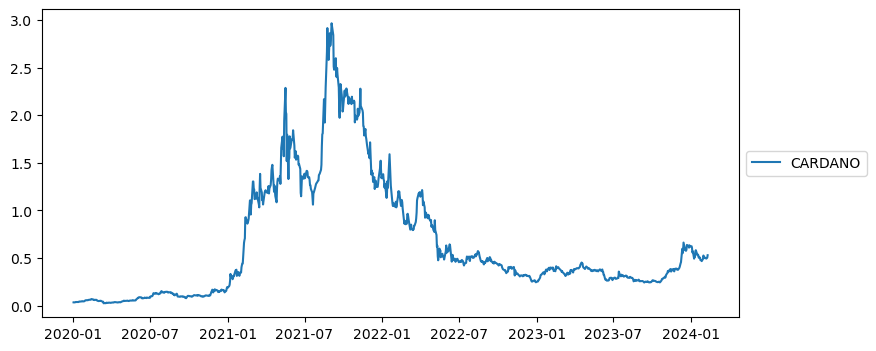

In [218]:
plotter(y)

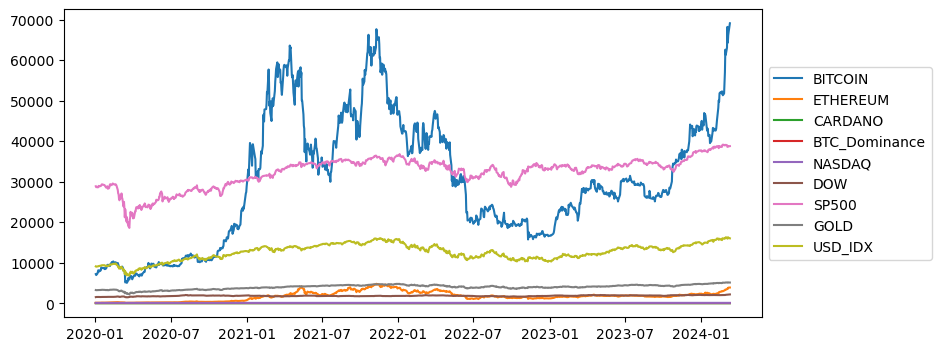

In [219]:
plotter(df)

In [221]:
# Now 'df_pct_change' is a new DataFrame with the same columns as 'df',
# but with values representing the percentage change from the previous row.
df_pct_change = df.pct_change()

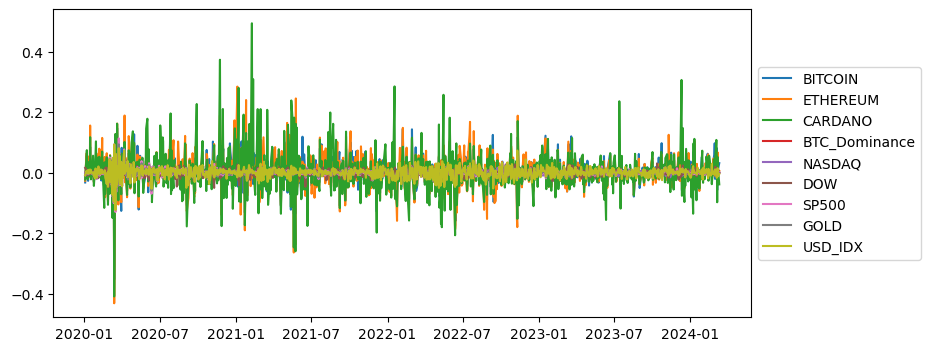

In [222]:
plotter(df_pct_change)

## 3. Modeling

### Decomposition

In [223]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonal_decomposition(time_series):
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(time_series, period= 1 )

    # Extract the trend, seasonal, and residual components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot the original data, trend, seasonal, and residuals
    plt.figure(figsize=(9, 9))

    # Original data
    plt.subplot(411)
    plt.plot(time_series, label='Original Data')
    plt.legend(loc='best')

    # Trend component
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')

    # Seasonal component
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='best')

    # Residual component
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()


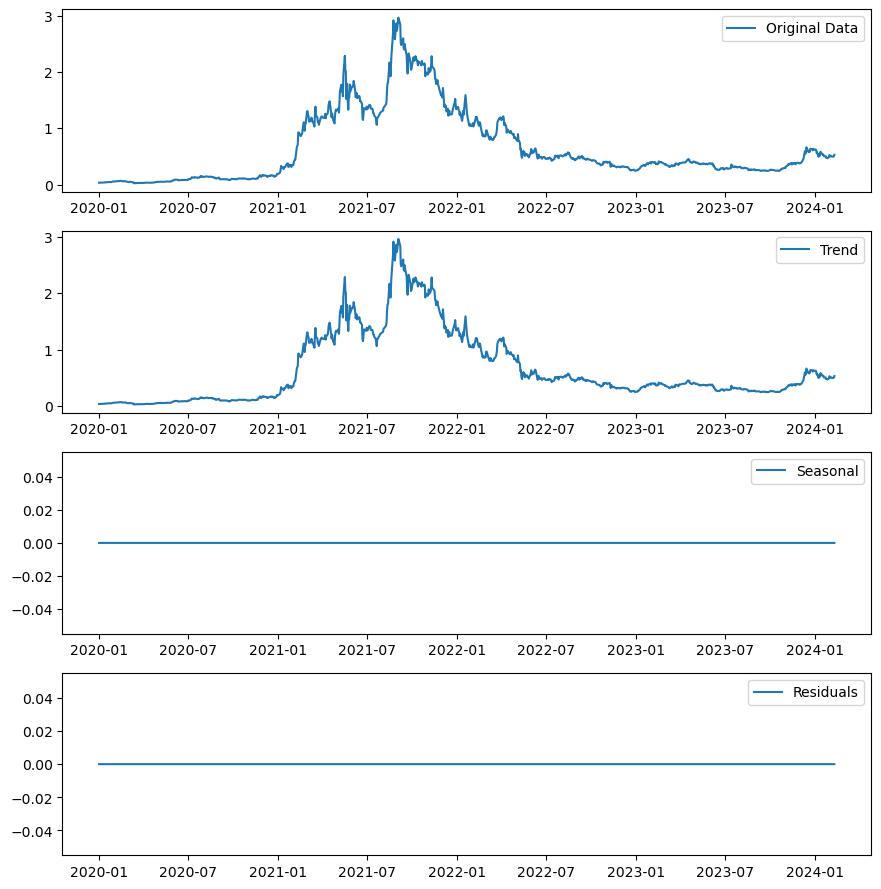

In [224]:
plot_seasonal_decomposition(y)

### Testing For Stationarity

In [168]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(time_series, p_val):
    print('Augmented Dickey-Fuller Test')
    print('Hypotheses: H0 (non-stationary) | Ha (stationary)')
    print('---------------------------')
    
    result = adfuller(time_series)
    labels = ['ADF Statistic', 'p-value', 'Number of Lags', 'Number of Observations']
    
    for value, label in zip(result, labels):
        print(label + ': ' + str(value))
        
    print('---------------------------')    
    if result[1] <= p_val:
        print("Conclusion: Strong evidence against the null hypothesis (H0).")
        print("Reject the null hypothesis. The data has no unit root and is stationary.")
    else:
        print("Conclusion: Weak evidence against the null hypothesis.")
        print("The time series has a unit root, indicating it is non-stationary.")

In [169]:
adfuller_test(y, 0.05)

Augmented Dickey-Fuller Test
Hypotheses: H0 (non-stationary) | Ha (stationary)
---------------------------
ADF Statistic: -1.721736441638154
p-value: 0.4199494342017266
Number of Lags: 22
Number of Observations: 1012
---------------------------
Conclusion: Weak evidence against the null hypothesis.
The time series has a unit root, indicating it is non-stationary.


In [170]:
y_diff = y.diff().dropna()

In [171]:
y_diff.describe().round(2)

count    1034.00
mean        0.00
std         0.06
min        -0.50
25%        -0.01
50%         0.00
75%         0.01
max         0.37
Name: CARDANO, dtype: float64

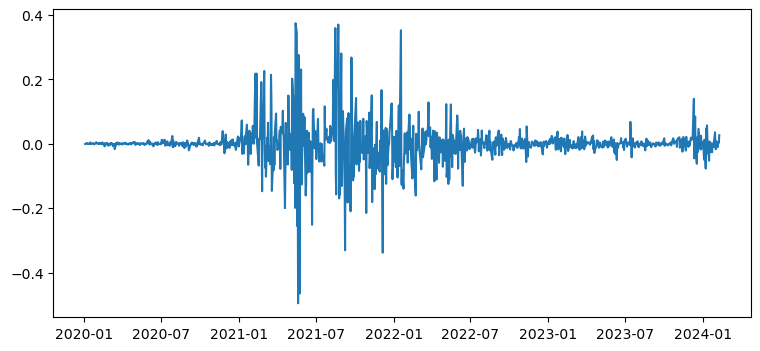

In [172]:
plotter(y_diff)

In [173]:
adfuller_test(y_diff, 0.05)

Augmented Dickey-Fuller Test
Hypotheses: H0 (non-stationary) | Ha (stationary)
---------------------------
ADF Statistic: -6.6772493178281005
p-value: 4.433149699935138e-09
Number of Lags: 21
Number of Observations: 1012
---------------------------
Conclusion: Strong evidence against the null hypothesis (H0).
Reject the null hypothesis. The data has no unit root and is stationary.


### ACF & PACF Plots

In [174]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(time_series, max_lags=50):
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    
    # Plot the ACF
    plot_acf(time_series, lags=max_lags, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')
    
    # Plot the PACF
    plot_pacf(time_series, lags=max_lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()

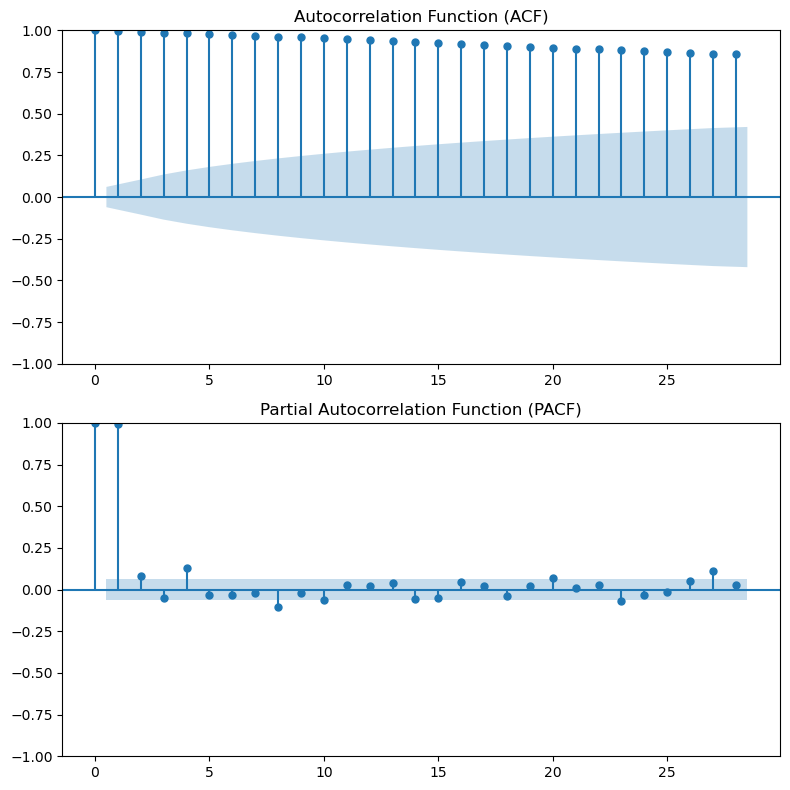

In [175]:
plot_acf_pacf(y,28)

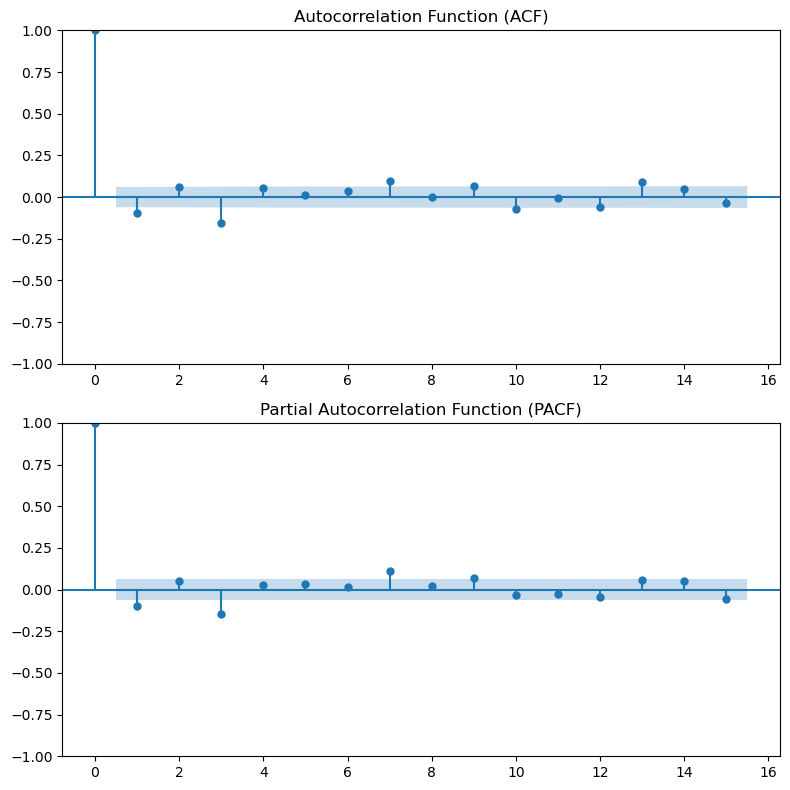

In [176]:
plot_acf_pacf(y_diff,15)

### The SARIMA model


In [177]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [178]:
def find_best_sarimax_params(data, max_ar=2, max_ma=2, max_s=2):
    p = d = q = range(0, max_ar) 
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(data,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                results = model.fit()

                if results.aic < best_aic:
                    best_aic = results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
            except:
                continue

    return best_pdq, best_seasonal_pdq


### Find the best SARIMA params

In [ ]:
best_params = find_best_sarimax_params(y)
print('Best ARIMA params:', best_params[0])
print('Best seasonal params:', best_params[1])

### Fit SARIMA model

In [ ]:
# specify the model
model = SARIMAX(y,
                order=best_params[0],              # specify your ARIMA order
                seasonal_order=best_params[1], # specify your seasonal order
                enforce_stationarity=False,   # depending on your data you might want to change these
                enforce_invertibility=False)

# fit the model
results = model.fit()

# get a summary of the model parameters and performance
print(results.summary())

# make predictions
pred = results.get_prediction(start=pd.to_datetime(BASE_DATE), dynamic=False)
pred_conf = pred.conf_int()

## 4. Forecast

In [ ]:

def plot_forecast(model_results, data, data_all, steps=6, start_date=None):
    # forecast for the next 'steps' periods
    forecast = model_results.get_forecast(steps=steps)
    forecast_ci = forecast.conf_int()

    # If a start date is provided, slice the data
    if start_date:
        data = data[start_date:]
        data_all = data_all[start_date:]

    # create a new row for the forecast confidence interval dataframe
    new_row = pd.DataFrame([[data.values[-1], data.values[-1]]], columns=forecast_ci.columns, index=[pd.to_datetime(data.index[-1])])

    # concatenate the new row and the original dataframe
    forecast_ci = pd.concat([new_row, forecast_ci])

    # set seaborn style
    sns.set(style='whitegrid')

    # set the figure size
    plt.figure(figsize=(16, 6))

    # plot the time series data
    sns.lineplot(data=data, color='k', label='Historical')
    sns.lineplot(data=data_all[BASE_DATE:], color='k', linestyle = 'dotted', label='Actual')


    forecast_index = pd.DatetimeIndex([data.index[-1]]).append(forecast.predicted_mean.index)
    forecast_values = np.append(np.array(data.values[-1]), forecast.predicted_mean.values)

    # plot your mean predictions
    sns.lineplot(x=forecast_index, y=forecast_values, color='b', label='Forecast')

    # shade the area between your confidence limits
    sns.lineplot(x=forecast_ci.index, y=forecast_ci.iloc[:, 0], color='r', alpha=0.1)
    sns.lineplot(x=forecast_ci.index, y=forecast_ci.iloc[:, 1], color='r', alpha=0.1)
    plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='b', alpha=0.1)

    plt.title('SARIMA model forecast for next {} periods'.format(steps))
    plt.xlabel('Date')
    plt.ylabel('Values')
    
    plt.axvline(x=BASE_DATE, c='gray', linewidth = 2.5, ls='--', alpha=0.8)

    plt.legend()
    plt.show()


In [ ]:
plot_forecast(results, y, df[TARGET_FEATURE],  PRED_STEPS, '2020-01-31')